In [1]:
import numpy as np
import pandas as pd
import timeit

%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
class NeuralNetwork:
    #Layers: an Integer value representing the total number of hidden layers in the network 
    #        (input and output layers are extra)

    def __init__(self, Layers, Nodes, NNodes, Activations, ActivationFn, a=None):
        self.Layers = Layers
        self.Nodes = Nodes
        self.NNodes = NNodes
        self.Activations = Activations
        self.ActivationFn = ActivationFn
        self.a = a # The coefficient used if using leaky Relu as the activation function, default is None
        self.weights = None
        
       
        
    # Forward Pass
        
    def Relu(self,e):
        return max(0,e)
    
    def leakyRelu(self,e):
        if e > 0:
            return e
        else:
            return self.a*e
        
    def sigmoid(self,e):
        return 1/(1+np.exp(1)**-e)
    
    def tanh(self,e):
        return 2*self.sigmoid(2*e) - 1
    
    def applyActivation(self,layer,i):
        acttype = self.Activations[i]
        if acttype == "Relu":
            return layer.applymap(self.Relu)
        elif acttype == "leaky":
            return layer.applymap(self.leakyRelu)
        elif acttype == "sigmoid":
            return layer.applymap(self.sigmoid)
        elif acttype == "tanh":
            return layer.applymap(self.tanh)
    
    def loss(self,z,y):
        # Performs L2 loss (for this project)
        L = 0.5*((np.array(z)-np.array(y))**2) # Assumes the squaring is element wise
        L = np.sum(L) * (1/len(z)) # Take average of all the losses
        return L     
        


    def forward_pass(self, X, y, weights):
            # Assume X already has a column of ones for bias term.
            # Assume weights include the weights for the bias term when going into next layer

            savings = [X]

            # From input layer to first hidden layer
            h = X.dot(weights[0]) # Get first hidden layer without the bias node added in
            h['ones'] = 1 # Add in bias node to the hidden layer
            savings.append(h) # Saving intermediate values
            hact = self.applyActivation(h,0) # Perform activation
            hact['ones'] = 1
            savings.append(hact) # Saving intermediate values
            h = hact

            for i in range(1,len(weights)):
                if i != len(weights)-1: # A hidden layer
                    h = h.dot(weights[i])
                    h['ones'] = 1 # Add in bias node to the hidden layer
                    savings.append(h) # Saving intermediate values
                    hact = self.applyActivation(h,i) # Perform activation
                    hact['ones'] = 1
                    savings.append(hact) # Saving intermediate values
                    h = hact
                else: # For Z value/vector
                    z = h.dot(weights[i])
                    savings.append(z)

                    # Calculate loss
                    L = self.loss(z,y)
                    savings.append(L) # Are we saving average loss over the batch?
            return savings
    
    # Backwards pass
    def J_loss(self,z,y):
        B = len(y)
        #print(z.subtract(y,axis=0))
        #J = (1/B)*(np.array(z) - np.array(y))
        J = (1/B)*(z.subtract(y,axis=0))
        return J
    
    def J_sigma(self, X, activation):
        if activation == "sigmoid":
            S = (1/(1+np.exp(-X)))
            return S.multiply(1-S)
        elif activation == "tanh":
            return 1-(X**2)
        elif activation == "Relu":
            return (X > 0).astype(int)
        elif activation == "leaky":
            return (X>0).astype(int) +  self.a*(X<0).astype(int)
        
    def J_inputlayer(self,J,w):
        #return J.dot(w.T)
        #print(w)
        #w = pd.DataFrame(w).drop([len(w)-1],axis=0)
        w = pd.DataFrame(w).iloc[:-1]
        return J.dot(w.T)
    
    def J_weight(self,J,X):
        return np.array(X.T).dot(J)
    
    def back_propagation(self,X,y,intermediates,weights,lr,batch):
        J = pd.DataFrame(self.J_loss(intermediates[-2],y)) # Compute the jacobian of the loss layer evaluated at z
        w_on = True
        w_count = len(weights)-1
        act_count = len(self.Activations) - 1
        for i in range(-3,-len(intermediates),-1):
            if w_on:
                J_wn = self.J_weight(J,intermediates[i])  # Calculate the jacobian of the weights evaluated at sigma
                J = self.J_inputlayer(J,weights[w_count])  # Update jacobian by computing the jacobian of dense layer wrt input
                weights[w_count] = weights[w_count] - lr*J_wn*(1/batch) # Update the weights
                w_count = w_count - 1 # Update the index for the next set of weights
                w_on = False # Next derivative evaluated at intermediates[i] will not update the weights
            else:
                J = np.multiply(J,self.J_sigma(intermediates[i].drop("ones",axis=1), self.Activations[act_count])) # For activation, we use element-wise multiplication
                w_on = True
                act_count = act_count-1
        # Update last set of weights (W_1)
        J_w1 = self.J_weight(J,intermediates[-len(intermediates)])
        weights[w_count] = weights[w_count] - lr*J_w1*(1/batch)
        return weights

    
    # Training
    
    def setup(self,width):
        if self.NNodes != None:
            self.Nodes = [width] + ([self.NNodes]*self.Layers) + [1]
        if self.ActivationFn != None:
            self.Activations = [self.ActivationFn]*(self.Layers+1) 
            


    def initialize_weights(self):
        weights = []
        for i in range(len(self.Nodes)-1):
            M = self.Nodes[i] 
            N = self.Nodes[i+1] 
            if self.Activations[i] in ["Relu","leaky"]:
                w = np.random.normal(loc=0,scale = np.sqrt(2/(M)),size=(M,N))
                w = np.append(w,[[0]*N], axis=0) # BIAS
                weights.append(w)
            else:
                w = np.random.normal(loc=0,scale = np.sqrt(2/(M+N)),size=(M,N)) 
                w = np.append(w,[[0]*N], axis=0) #BIAS
                weights.append(w)
        return weights
    
    def train(self,X,y,lr,batch,max_epoch,eps):
        Xsamp = X.sample(batch)
        ysamp = y.loc[Xsamp.index]
        Losses = []
        
        # Set up
        self.setup(Xsamp.shape[1])
        
        # first iteration
        epoch = 1
        weights = self.initialize_weights()
        Xsamp["ones"] = 1
        intermediates = self.forward_pass(Xsamp,ysamp,weights)
        weights = self.back_propagation(Xsamp,ysamp,intermediates,weights,lr,batch)
        L0 = intermediates[-1]
        Losses.append(L0)
        print("epoch:",epoch,"    Loss:",L0)
        while(L0 > eps):
            Xsamp = X.sample(batch)
            ysamp = y.loc[Xsamp.index]
            Xsamp["ones"] = 1
            intermediates = self.forward_pass(Xsamp,ysamp,weights)
            weights = self.back_propagation(Xsamp,ysamp,intermediates,weights,lr,batch)
            L0 = intermediates[-1]
            Losses.append(L0)
            epoch = epoch + 1
            print("epoch:",epoch,"    Loss:",L0)
            if epoch == max_epoch:
                break
            if np.abs(Losses[-1]-Losses[-2]) < eps:
                lr = lr/2
                print('reduced the learning rate in half to', lr)
        self.weights = weights
        print("epoch:",epoch,"    Loss:",L0)
        #print("epoch:",epoch)
        #return L0
        return Losses
    
    def predict(self,X_test,y_test):
        X_test["ones"] = 1
        intermediates = self.forward_pass(X_test,y_test,self.weights)
        predictions = intermediates[-2]
        return predictions

In [18]:
# class NeuralNetwork:
#     #Layers: an Integer value representing the total number of hidden layers in the network 
#     #        (input and output layers are extra)

#     def __init__(self, Layers, Nodes, NNodes, Activations, ActivationFn, a=None):
#         self.Layers = Layers
#         self.Nodes = Nodes
#         self.NNodes = NNodes
#         self.Activations = Activations
#         self.ActivationFn = ActivationFn
#         self.a = a # The coefficient used if using leaky Relu as the activation function, default is None
#         self.weights = None
        
       
        
#     # Forward Pass
        
#     def Relu(self,e):
#         return max(0,e)
    
#     def leakyRelu(self,e):
#         if e > 0:
#             return e
#         else:
#             return self.a*e
        
#     def sigmoid(self,e):
#         return 1/(1+np.exp(1)**-e)
    
#     def tanh(self,e):
#         return 2*self.sigmoid(2*e) - 1
    
#     def applyActivation(self,layer,i):
#         acttype = self.Activations[i]
#         if acttype == "Relu":
#             return layer.applymap(self.Relu)
#         elif acttype == "leaky":
#             return layer.applymap(self.leakyRelu)
#         elif acttype == "sigmoid":
#             return layer.applymap(self.sigmoid)
#         elif acttype == "tanh":
#             return layer.applymap(self.tanh)
    
#     def loss(self,z,y):
#         # Performs L2 loss (for this project)
#         L = 0.5*((np.array(z)-np.array(y))**2) # Assumes the squaring is element wise
#         L = np.sum(L) * (1/len(z)) # Take average of all the losses
#         return L     
        


#     def forward_pass(self, X, y, weights):
#             # Assume X already has a column of ones for bias term.
#             # Assume weights include the weights for the bias term when going into next layer

#             savings = [X]

#             # From input layer to first hidden layer
#             h = X.dot(weights[0]) # Get first hidden layer without the bias node added in
#             h['ones'] = 1 # Add in bias node to the hidden layer
#             savings.append(h) # Saving intermediate values
#             hact = self.applyActivation(h,0) # Perform activation
#             hact['ones'] = 1
#             savings.append(hact) # Saving intermediate values
#             h = hact

#             for i in range(1,len(weights)):
#                 if i != len(weights)-1: # A hidden layer
#                     h = h.dot(weights[i])
#                     h['ones'] = 1 # Add in bias node to the hidden layer
#                     savings.append(h) # Saving intermediate values
#                     hact = self.applyActivation(h,i) # Perform activation
#                     hact['ones'] = 1
#                     savings.append(hact) # Saving intermediate values
#                     h = hact
#                 else: # For Z value/vector
#                     z = h.dot(weights[i])
#                     savings.append(z)

#                     # Calculate loss
#                     L = self.loss(z,y)
#                     savings.append(L) # Are we saving average loss over the batch?
#             return savings
    
#     # Backwards pass
#     def J_loss(self,z,y):
#         B = len(y)
#         #print(z.subtract(y,axis=0))
#         #J = (1/B)*(np.array(z) - np.array(y))
#         J = (1/B)*(z.subtract(y,axis=0))
#         return J
    
#     def J_sigma(self, X, activation):
#         if activation == "sigmoid":
#             S = (1/(1+np.exp(-X)))
#             return S.multiply(1-S)
#         elif activation == "tanh":
#             return 1-(X**2)
#         elif activation == "Relu":
#             return (X > 0).astype(int)
#         elif activation == "leaky":
#             return (X>0).astype(int) +  self.a*(X<0).astype(int)
        
#     def J_inputlayer(self,J,w):
#         #return J.dot(w.T)
#         #print(w)
#         #w = pd.DataFrame(w).drop([len(w)-1],axis=0)
#         w = pd.DataFrame(w).iloc[:-1]
#         return J.dot(w.T)
    
#     def J_weight(self,J,X):
#         return np.array(X.T).dot(J)
    
#     def back_propagation(self,X,y,intermediates,weights,lr,batch):
#         J = pd.DataFrame(self.J_loss(intermediates[-2],y)) # Compute the jacobian of the loss layer evaluated at z
#         w_on = True
#         w_count = len(weights)-1
#         act_count = len(self.Activations) - 1
#         for i in range(-3,-len(intermediates),-1):
#             if w_on:
#                 J_wn = self.J_weight(J,intermediates[i])  # Calculate the jacobian of the weights evaluated at sigma
#                 J = self.J_inputlayer(J,weights[w_count])  # Update jacobian by computing the jacobian of dense layer wrt input
#                 weights[w_count] = weights[w_count] - lr*J_wn*(1/batch) # Update the weights
#                 w_count = w_count - 1 # Update the index for the next set of weights
#                 w_on = False # Next derivative evaluated at intermediates[i] will not update the weights
#             else:
#                 J = np.multiply(J,self.J_sigma(intermediates[i].drop("ones",axis=1), self.Activations[act_count])) # For activation, we use element-wise multiplication
#                 w_on = True
#                 act_count = act_count-1
#         # Update last set of weights (W_1)
#         J_w1 = self.J_weight(J,intermediates[-len(intermediates)])
#         weights[w_count] = weights[w_count] - lr*J_w1*(1/batch)
#         return weights

    
#     # Training
    
#     def setup(self,width):
#         if self.NNodes != None:
#             self.Nodes = [width] + ([self.NNodes]*self.Layers) + [1]
#         if self.ActivationFn != None:
#             self.Activations = [self.ActivationFn]*(self.Layers+1) 
            


#     def initialize_weights(self):
#         weights = []
#         for i in range(len(self.Nodes)-1):
#             M = self.Nodes[i] 
#             N = self.Nodes[i+1] 
#             if self.Activations[i] in ["Relu","leaky"]:
#                 w = np.random.normal(loc=0,scale = np.sqrt(2/(M)),size=(M,N))
#                 w = np.append(w,[[0]*N], axis=0) # BIAS
#                 weights.append(w)
#             else:
#                 w = np.random.normal(loc=0,scale = np.sqrt(2/(M+N)),size=(M,N)) 
#                 w = np.append(w,[[0]*N], axis=0) #BIAS
#                 weights.append(w)
#         return weights
    
#     def train(self,X,y,lr,batch,max_epoch,eps,alpha):
#         Xsamp = X.sample(batch)
#         ysamp = y.loc[Xsamp.index]
#         Losses = []
        
#         # Set up
#         self.setup(Xsamp.shape[1])
        
#         # first iteration
#         epoch = 1
#         weights = self.initialize_weights()
#         Xsamp["ones"] = 1
#         intermediates = self.forward_pass(Xsamp,ysamp,weights)
#         weights = self.back_propagation(Xsamp,ysamp,intermediates,weights,lr,batch)
#         L0 = intermediates[-1]
#         Losses.append(L0)
#         print("epoch:",epoch,"    Loss:",L0)
#         while(L0 > eps):
#             Xsamp = X.sample(batch)
#             ysamp = y.loc[Xsamp.index]
#             Xsamp["ones"] = 1
#             intermediates = self.forward_pass(Xsamp,ysamp,weights)
#             if intermediates[-1] > L0:
#                 print("Went up")
#                 lr = lr*alpha
#             weights = self.back_propagation(Xsamp,ysamp,intermediates,weights,lr,batch)
#             L0 = intermediates[-1]
#             Losses.append(L0)
#             epoch = epoch + 1
        
#             print("epoch:",epoch,"    Loss:",L0)
#             if epoch == max_epoch:
#                 break
#             if np.abs(Losses[-1]-Losses[-2]) < eps:
#                 lr = lr/2
#                 print('reduced the learning rate in half to', lr)
#         self.weights = weights
#         print("epoch:",epoch,"    Loss:",L0)
#         #print("epoch:",epoch)
#         #return L0
#         return Losses
    
#     def predict(self,X_test,y_test):
#         X_test["ones"] = 1
#         intermediates = self.forward_pass(X_test,y_test,self.weights)
#         predictions = intermediates[-2]
#         return predictions

# ---------------------------------Feature Selection-------------------------------

In [3]:
df = pd.read_csv('datasets/sberbank-russian-housing-market/train.csv')
df = df.select_dtypes(exclude=['category', 'object'])
df = df.drop(['id'], axis=1)

In [4]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
df = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)

In [5]:
df_corr = df.corr()
df_corr

,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,state,area_m,...,cafe_count_5000_price_2500,cafe_count_5000_price_4000,cafe_count_5000_price_high,big_church_count_5000,church_count_5000,mosque_count_5000,leisure_count_5000,sport_count_5000,market_count_5000,price_doc
full_sq,1.000000,0.161112,0.089649,0.119225,0.032866,-0.006041,0.695444,0.020026,-0.091348,0.056303,...,0.039083,0.040059,0.043560,0.026895,0.028579,0.021568,0.030218,0.001580,-0.041254,0.341840
life_sq,0.161112,1.000000,0.045090,0.042442,0.011393,-0.002401,0.191024,0.000633,-0.066633,0.061395,...,0.028735,0.031551,0.034888,0.017845,0.018114,0.009945,0.022737,-0.014499,-0.050337,0.165606
floor,0.089649,0.045090,1.000000,0.454488,-0.009043,0.001192,-0.005657,-0.008457,-0.113906,-0.019448,...,-0.034791,-0.029636,-0.022303,-0.044398,-0.045614,-0.012256,-0.044236,-0.102101,-0.123843,0.117447
max_floor,0.119225,0.042442,0.454488,1.000000,0.045915,-0.000261,-0.014220,0.020345,-0.072161,-0.092954,...,-0.040235,-0.033662,-0.029525,-0.048235,-0.048240,-0.058255,-0.048664,-0.099855,-0.113341,0.094386
material,0.032866,0.011393,-0.009043,0.045915,1.000000,-0.004402,-0.026924,0.038747,-0.034225,0.001182,...,0.050919,0.043660,0.044403,0.038480,0.044701,0.050355,0.044502,0.098482,0.076378,0.064047
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
mosque_count_5000,0.021568,0.009945,-0.012256,-0.058255,0.050355,0.019631,0.062785,0.013183,0.091894,-0.086786,...,0.529434,0.492859,0.481481,0.502028,0.550342,1.000000,0.499376,0.518500,0.242078,0.175107
leisure_count_5000,0.030218,0.022737,-0.044236,-0.048664,0.044502,-0.000830,0.058663,-0.006259,-0.003876,-0.195067,...,0.986206,0.975462,0.948391,0.969029,0.975259,0.499376,1.000000,0.809169,0.463053,0.200448
sport_count_5000,0.001580,-0.014499,-0.102101,-0.099855,0.098482,0.005978,0.089908,0.016866,0.194379,-0.416222,...,0.824139,0.778770,0.753384,0.825883,0.847771,0.518500,0.809169,1.000000,0.733897,0.294864
market_count_5000,-0.041254,-0.050337,-0.123843,-0.113341,0.076378,0.007362,0.061674,0.026404,0.273385,-0.449849,...,0.432265,0.380154,0.353270,0.482547,0.514344,0.242078,0.463053,0.733897,1.000000,0.194021


In [7]:
remove_cols = set()
for col1 in df.columns:
    if col1 in remove_cols or col1 == 'price_doc':
        continue
        
    for col2 in df.columns:
        if col1 == col2 or col2 in remove_cols or col2 == 'price_doc':
            continue
            
        if abs(df_corr[col1][col2]) > 0.80:
            remove_cols.add(col2)
            
df = df.drop(list(remove_cols), axis=1)

In [8]:
df

,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,state,area_m,...,mosque_count_3000,market_count_3000,green_part_5000,prom_part_5000,office_sqm_5000,trc_sqm_5000,cafe_sum_5000_min_price_avg,mosque_count_5000,market_count_5000,price_doc
0,-0.294873,-0.141596,-0.690013,NaN,NaN,NaN,NaN,NaN,NaN,-0.544788,...,-0.444553,-0.581088,-0.863607,0.522405,-0.257781,2.849088,-0.370906,0.915176,-0.406425,-0.266324
1,-0.531523,-0.294604,-0.877987,NaN,NaN,NaN,NaN,NaN,NaN,-0.390702,...,-0.444553,-0.581088,-1.116099,3.020352,0.559878,0.856963,-0.598980,0.915176,1.638925,-0.234943
2,-0.294873,-0.103343,-1.065960,NaN,NaN,NaN,NaN,NaN,NaN,-0.622239,...,-0.444553,1.620098,-0.810075,1.981305,0.033479,0.397215,-0.409553,-0.726162,0.820785,-0.297704
3,0.914671,0.298304,0.249854,NaN,NaN,NaN,NaN,NaN,NaN,-0.245700,...,-0.444553,0.299386,-0.766358,-1.139365,-0.502338,-0.230586,1.092352,-0.726162,-0.610960,1.250402
4,0.599138,0.814708,-0.690013,NaN,NaN,NaN,NaN,NaN,NaN,-0.448374,...,1.788546,1.179861,-1.283832,0.100788,3.041043,2.318075,0.582531,2.556515,1.638925,1.926434
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30466,-0.268578,-0.141596,-0.126093,-0.526757,-0.558443,-0.007080,0.105890,-0.014127,1.014604,-0.368245,...,1.788546,0.299386,-0.646803,1.215691,-0.244226,1.367864,-0.493079,0.915176,0.002645,0.057942
30467,0.835788,0.470439,-0.877987,-0.526757,0.116722,-0.007339,2.453903,0.127389,1.014604,-0.501211,...,1.788546,0.739624,-1.291862,0.441257,3.711998,3.156912,0.802667,0.915176,1.843460,3.739925
30468,-0.242284,NaN,0.437827,1.101332,-0.558443,NaN,-1.068116,-0.191022,-1.257808,0.381575,...,-0.444553,-1.021326,1.146513,-0.597791,-0.557425,-0.967931,-0.116324,-0.726162,-1.020030,-0.031815
30469,0.257310,-0.045965,-0.502040,0.361292,-0.558443,-0.006899,0.105890,0.162768,-0.121602,-0.562102,...,1.788546,0.739624,0.677217,-0.179702,-0.076137,0.289263,-0.406141,0.915176,0.207180,1.334084


In [9]:
from sklearn.impute import KNNImputer
imputer = KNNImputer(n_neighbors=2)
df = pd.DataFrame(imputer.fit_transform(df), columns = df.columns)

In [3]:
df.to_csv("imputed.csv")

NameError: name 'df' is not defined

In [6]:
df = pd.read_csv("imputed.csv")

In [7]:
NUM_FEATURES = 30
highest_corrs = abs(df_corr['price_doc']).sort_values(ascending=False)[1:]
features = ['price_doc']
c = 0
for feat in highest_corrs.index:
    if feat in set(df.columns):
        features.append(feat)
        c += 1
        
    if c >= NUM_FEATURES:
        break

In [8]:
df = df[features]
df

,price_doc,num_room,full_sq,ttk_km,office_sqm_5000,trc_sqm_5000,sport_objects_raion,trc_count_3000,office_km,university_km,...,build_count_brick,area_m,mosque_km,university_top_20_raion,life_sq,big_road2_km,leisure_count_500,bus_terminal_avto_km,green_part_5000,office_sqm_1000
0,-0.266324,0.692894,-0.294873,-0.049533,-0.257781,2.849088,0.055535,1.023667,-0.595638,-0.020927,...,-0.836822,-0.544788,-0.658647,-0.311624,-0.141596,0.232085,-0.182697,1.950381,-0.863607,-0.220835
1,-0.234943,-1.068116,-0.531523,-1.018286,0.559878,0.856963,-0.096628,0.199057,-0.573262,-0.743285,...,-0.317916,-0.390702,-0.501302,-0.311624,-0.294604,-0.156390,-0.182697,-0.584616,-1.116099,0.169153
2,-0.297704,0.692894,-0.294873,-1.040167,0.033479,0.397215,-0.248792,-0.442306,-0.202880,-0.893523,...,0.758619,-0.622239,0.031644,-0.311624,-0.103343,-0.250714,-0.182697,-0.447654,-0.810075,-0.432860
3,1.250402,1.279897,0.914671,0.407647,-0.502338,-0.230586,1.577171,0.015810,-0.466830,0.601255,...,0.123541,-0.245700,1.308094,-0.311624,0.298304,-0.329289,-0.182697,-0.444337,-0.766358,-0.356392
4,1.926434,1.866900,0.599138,-1.189629,3.041043,2.318075,2.794480,4.413731,-0.838131,-0.871176,...,4.143123,-0.448374,-0.891795,4.195022,0.814708,-0.140607,4.993465,-1.168734,-1.283832,2.493453
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30466,0.057942,0.105890,-0.268578,-0.366481,-0.244226,1.367864,0.512026,0.932044,-0.393423,-0.686202,...,-0.681925,-0.368245,-1.069206,-0.311624,-0.141596,0.195457,-0.182697,0.744946,-0.646803,-0.432860
30467,3.739925,2.453903,0.835788,-1.249518,3.711998,3.156912,3.403134,1.481784,-0.841563,-0.918569,...,3.260209,-0.501211,-0.953783,4.195022,0.470439,-1.149437,2.405384,-0.793643,-1.291862,7.516276
30468,-0.031815,-1.068116,-0.242284,0.722801,-0.557425,-0.967931,-1.009610,-0.900423,1.009136,0.896963,...,0.046092,0.381575,0.850076,-0.311624,0.135733,0.155911,-0.182697,1.005774,1.146513,-0.432860
30469,1.334084,0.105890,0.257310,-0.294774,-0.076137,0.289263,0.664190,1.206914,-0.349537,-0.723989,...,-0.805843,-0.562102,-0.863477,1.941699,-0.045965,-0.653367,-0.182697,-0.618366,0.677217,-0.432860


In [9]:
#df.to_csv("final_df.csv")

# -------------------------------Running the Neural Network---------------------------

In [3]:
df = pd.read_csv("final_df.csv").drop("Unnamed: 0", axis=1)
#df = df.sample(frac=1)
#df

In [4]:
X = df.drop('price_doc', axis=1)
y = df['price_doc']

# X_train = X.iloc[:int(len(X)/2)]
# y_train = y.iloc[:int(len(X)/2)]
# X_test = X.iloc[int(len(X)/2)+1:]
# y_test = y.iloc[int(len(X)/2)+1:]

X_train = X.iloc[:int(len(X)*0.8)]
y_train = y.iloc[:int(len(X)*0.8)]
X_test = X.iloc[int(len(X)*0.8)+1:]
y_test = y.iloc[int(len(X)*0.8)+1:]

In [5]:
from sklearn.datasets import load_boston
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_absolute_error

In [33]:
mlp = MLPRegressor(hidden_layer_sizes=(1000,500,100,50,25,10),activation='tanh',
                   batch_size=10000,
                   solver='sgd',learning_rate_init=0.00001,momentum=0,
                   learning_rate='constant',
                   max_iter=100,
                   tol=0.0001,
                   verbose=True).fit(X_train,y_train)

Iteration 1, loss = 0.56547856
Iteration 2, loss = 0.56515539
Iteration 3, loss = 0.56483056
Iteration 4, loss = 0.56450413
Iteration 5, loss = 0.56417978
Iteration 6, loss = 0.56385454
Iteration 7, loss = 0.56353304
Iteration 8, loss = 0.56320860
Iteration 9, loss = 0.56288547
Iteration 10, loss = 0.56256255
Iteration 11, loss = 0.56224159
Iteration 12, loss = 0.56192169
Iteration 13, loss = 0.56160148
Iteration 14, loss = 0.56128237
Iteration 15, loss = 0.56096692
Iteration 16, loss = 0.56065058
Iteration 17, loss = 0.56033171
Iteration 18, loss = 0.56001649
Iteration 19, loss = 0.55970141
Iteration 20, loss = 0.55938739
Iteration 21, loss = 0.55907568
Iteration 22, loss = 0.55876305
Iteration 23, loss = 0.55844969
Iteration 24, loss = 0.55814072
Iteration 25, loss = 0.55783075
Iteration 26, loss = 0.55752230
Iteration 27, loss = 0.55721456
Iteration 28, loss = 0.55690584
Iteration 29, loss = 0.55659828
Iteration 30, loss = 0.55629046
Iteration 31, loss = 0.55598508
Iteration 32, los

/opt/tljh/user/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


In [34]:
mae = mean_absolute_error(y_test,mlp.predict(X_test))
print('Mean absolute error: %0.2f'%(mae))

Mean absolute error: 0.74


In [6]:
#NN = NeuralNetwork(Layers=4, Nodes=[30,30,30,20,10,1], NNodes=None, Activations=["Relu","tanh","Relu","tanh","Relu"], ActivationFn=None, a=None)
#NN = NeuralNetwork(Layers=4, Nodes=[50,50,50,50,50,1], NNodes=None, Activations=["Relu","tanh","Relu","tanh","Relu"], ActivationFn=None, a=None)
NN = NeuralNetwork(Layers=1, Nodes=[50,30,1], NNodes=None, Activations=["Relu","Relu"], ActivationFn=None, a=None)
start_time = timeit.default_timer()
res = NN.train(X_train,y_train,100,len(X_train),50,10**-3)
#res = NN.train(X_train,y_train,0.00001,10000,100,10**-3)
elapsed = timeit.default_timer() - start_time
print("Time (minutes) elapsed for this cell:", elapsed/60)
print("Loss:", res[-1])

epoch: 1     Loss: 46928.23407159267
epoch: 2     Loss: 43420.76709561882
epoch: 3     Loss: 40453.84887747204
epoch: 4     Loss: 37935.847378813785
epoch: 5     Loss: 35790.99258845469
epoch: 6     Loss: 33958.34920616745
epoch: 7     Loss: 32387.17564174714
epoch: 8     Loss: 31035.488309492408
epoch: 9     Loss: 29868.61729386991
epoch: 10     Loss: 28857.723879722773
epoch: 11     Loss: 27978.730371646285
epoch: 12     Loss: 27211.145172642933
epoch: 13     Loss: 26538.38041044193
epoch: 14     Loss: 25946.115237595066
epoch: 15     Loss: 25422.42713142024
epoch: 16     Loss: 24957.397721770656
epoch: 17     Loss: 24542.491346117447
epoch: 18     Loss: 24170.517027393413
epoch: 19     Loss: 23835.482229013578
epoch: 20     Loss: 23532.190275682042
epoch: 21     Loss: 23256.28442471056
epoch: 22     Loss: 23004.096590269288
epoch: 23     Loss: 22772.459832148477
epoch: 24     Loss: 22558.707939744516
epoch: 25     Loss: 22360.70386121987
epoch: 26     Loss: 22176.48432923087
epoch: 

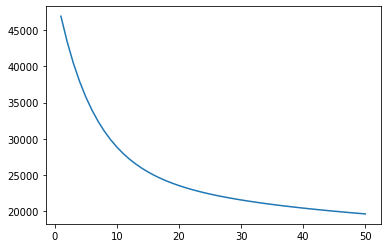

In [7]:
fig = plt.figure()
ax = plt.axes()

x = np.linspace(1, len(res), 50)
ax.plot(x, res);

In [8]:
np.sqrt(np.mean((np.array(y_test)-np.array((NN.predict(X_test,y_test))))**2))

/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:200: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


1.4065568599093314

In [9]:
df = pd.read_csv('datasets/sberbank-russian-housing-market/train.csv')


In [10]:
def inverseTrans(y):
    mu = df["price_doc"].mean()
    std = df["price_doc"].std()
    return y*std+mu

In [11]:
np.sqrt(np.mean((np.array(inverseTrans(y_test))-np.array(inverseTrans(NN.predict(X_test,y_test)).iloc[:,0]))**2))

/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:200: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


6419199.982638593

In [36]:
NN = NeuralNetwork(Layers=1, Nodes=[50,30,1], NNodes=None, Activations=["Relu","tanh","Relu"], ActivationFn=None, a=None)
start_time = timeit.default_timer()
res = NN.train(X_train,y_train,50,2048,50,10**-3)
elapsed = timeit.default_timer() - start_time
print("Time (minutes) elapsed for this cell:", elapsed/60)
print("Loss:", res[-1])

epoch: 1     Loss: 2518.054615018336
epoch: 2     Loss: 2305.0294666925197
epoch: 3     Loss: 1479.0493393421416
epoch: 4     Loss: 1993.5808085653177
epoch: 5     Loss: 1259.3757409742634
epoch: 6     Loss: 1300.6289507502597
epoch: 7     Loss: 1163.6200663692775
epoch: 8     Loss: 1373.3749327311039
epoch: 9     Loss: 1248.3397275055809
epoch: 10     Loss: 1452.220407965829
epoch: 11     Loss: 1571.4425382778588
epoch: 12     Loss: 1326.0910484497324
epoch: 13     Loss: 1272.9690024724173
epoch: 14     Loss: 1326.3697005560748
epoch: 15     Loss: 1409.2860819494886
epoch: 16     Loss: 1164.5573586899595
epoch: 17     Loss: 1341.0254469430263
epoch: 18     Loss: 1366.3284905190103
epoch: 19     Loss: 1531.3517887161415
epoch: 20     Loss: 1395.7642632040813
epoch: 21     Loss: 1478.6965042962022
epoch: 22     Loss: 1256.3663646366604
epoch: 23     Loss: 1239.717023888246
epoch: 24     Loss: 1629.2776945467435
epoch: 25     Loss: 1237.1561948162034
epoch: 26     Loss: 1439.877837995205

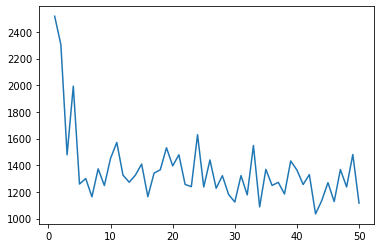

In [37]:
fig = plt.figure()
ax = plt.axes()

x = np.linspace(1, len(res), 50)
ax.plot(x, res);

In [38]:
np.sqrt(np.mean((np.array(inverseTrans(y_test))-np.array(inverseTrans(NN.predict(X_test,y_test)).iloc[:,0]))**2))

/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:200: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


4521217.746500798

In [32]:
4096*2

8192

In [57]:
NN = NeuralNetwork(Layers=1, Nodes=[50,30,1], NNodes=None, Activations=["Relu","tanh","Relu"], ActivationFn=None, a=None)
start_time = timeit.default_timer()
res = NN.train(X_train,y_train,100,4096,250,10**-3)
elapsed = timeit.default_timer() - start_time
print("Time (minutes) elapsed for this cell:", elapsed/60)
print("Loss:", res[-1])

epoch: 1     Loss: 5236.973771271211
epoch: 2     Loss: 4153.260472739055
epoch: 3     Loss: 3433.369214794716
epoch: 4     Loss: 3233.260991653439
epoch: 5     Loss: 2836.0336078725554
epoch: 6     Loss: 2833.150436856567
epoch: 7     Loss: 3284.813326573999
epoch: 8     Loss: 2898.9314071857298
epoch: 9     Loss: 2920.0876835531008
epoch: 10     Loss: 2713.9119548400854
epoch: 11     Loss: 3218.0574401980084
epoch: 12     Loss: 2629.1534346830144
epoch: 13     Loss: 3343.159408703336
epoch: 14     Loss: 2670.8730744610125
epoch: 15     Loss: 2825.0079839215264
epoch: 16     Loss: 2707.9104631917617
epoch: 17     Loss: 2806.875173707373
epoch: 18     Loss: 2758.2192326822988
epoch: 19     Loss: 2640.460193502341
epoch: 20     Loss: 2502.7378115337224
epoch: 21     Loss: 2667.4751417025404
epoch: 22     Loss: 2927.2055789640417
epoch: 23     Loss: 2570.4648897091624
epoch: 24     Loss: 2710.4580478024427
epoch: 25     Loss: 2686.6033091520803
epoch: 26     Loss: 3075.565910296136
epoch

epoch: 212     Loss: 2603.6061236885766
epoch: 213     Loss: 2695.67836255343
epoch: 214     Loss: 2835.3853408760647
epoch: 215     Loss: 3049.6601897380124
epoch: 216     Loss: 2685.492778658389
epoch: 217     Loss: 2622.808142747849
epoch: 218     Loss: 2577.650945776372
epoch: 219     Loss: 2572.360329797766
epoch: 220     Loss: 2889.4246395995388
epoch: 221     Loss: 2738.8446480428465
epoch: 222     Loss: 2360.2067069301775
epoch: 223     Loss: 2548.2894832125944
epoch: 224     Loss: 2711.4536649863926
epoch: 225     Loss: 2860.1507225756054
epoch: 226     Loss: 2409.149247487019
epoch: 227     Loss: 2637.07476868028
epoch: 228     Loss: 2525.519766131594
epoch: 229     Loss: 2501.325674553146
epoch: 230     Loss: 2640.2588435975476
epoch: 231     Loss: 2600.147565584933
epoch: 232     Loss: 2848.8208609129315
epoch: 233     Loss: 2636.9625268395926
epoch: 234     Loss: 2503.7638451057337
epoch: 235     Loss: 2440.0068145806868
epoch: 236     Loss: 3000.350753208822
epoch: 237   

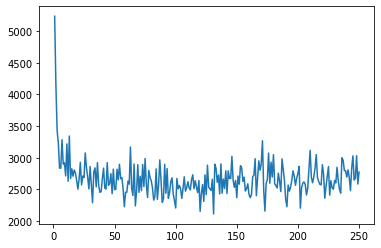

In [59]:
fig = plt.figure()
ax = plt.axes()

x = np.linspace(1, len(res), 250)
ax.plot(x, res);

In [60]:
np.sqrt(np.mean((np.array(inverseTrans(y_test))-np.array(inverseTrans(NN.predict(X_test,y_test)).iloc[:,0]))**2))

/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:200: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


4110136.1125037777

In [76]:
NN = NeuralNetwork(Layers=1, Nodes=[50,30,1], NNodes=None, Activations=["Relu","tanh","Relu"], ActivationFn=None, a=None)
start_time = timeit.default_timer()
res = NN.train(X_train,y_train,110,4096,300,10**-3)
elapsed = timeit.default_timer() - start_time
print("Time (minutes) elapsed for this cell:", elapsed/60)
print("Loss:", res[-1])

epoch: 1     Loss: 4529.599536895537
epoch: 2     Loss: 4358.168182250656
epoch: 3     Loss: 4168.643309431091
epoch: 4     Loss: 3666.8505273551546
epoch: 5     Loss: 3775.965883023725
epoch: 6     Loss: 3165.4467440051835
epoch: 7     Loss: 3237.183518370745
epoch: 8     Loss: 3300.665430369953
epoch: 9     Loss: 3101.198080224409
epoch: 10     Loss: 3134.6664630879864
epoch: 11     Loss: 2959.5454716927884
epoch: 12     Loss: 3077.737147176847
epoch: 13     Loss: 3319.889971672279
epoch: 14     Loss: 2638.61993336069
epoch: 15     Loss: 2884.224377478445
epoch: 16     Loss: 2874.1980834844935
epoch: 17     Loss: 2846.101235845135
epoch: 18     Loss: 2579.9060649025973
epoch: 19     Loss: 2643.136731666004
epoch: 20     Loss: 2554.374510831466
epoch: 21     Loss: 3012.3540476463586
epoch: 22     Loss: 2959.0634516185987
epoch: 23     Loss: 3211.6363520940413
epoch: 24     Loss: 2826.484210118711
epoch: 25     Loss: 3043.344674849068
epoch: 26     Loss: 2656.282428212346
epoch: 27    

epoch: 212     Loss: 2683.3223329872776
epoch: 213     Loss: 2753.3968804527585
epoch: 214     Loss: 2640.288954769803
epoch: 215     Loss: 2840.6686296190087
epoch: 216     Loss: 2584.768447090318
epoch: 217     Loss: 2610.9530915677346
epoch: 218     Loss: 2684.489247786194
epoch: 219     Loss: 2539.2834326423554
epoch: 220     Loss: 2860.7420140967656
epoch: 221     Loss: 3154.0865364530805
epoch: 222     Loss: 2955.187357998599
epoch: 223     Loss: 2755.8793836069067
epoch: 224     Loss: 2452.5977947596043
epoch: 225     Loss: 2828.859288388242
epoch: 226     Loss: 2506.7725720265607
epoch: 227     Loss: 2855.634688738619
epoch: 228     Loss: 2869.846675104022
epoch: 229     Loss: 2398.1095525583373
epoch: 230     Loss: 2706.8522426005425
epoch: 231     Loss: 2791.7269252562373
epoch: 232     Loss: 2645.3994279361973
epoch: 233     Loss: 2608.3018493133122
epoch: 234     Loss: 3198.6034072133903
epoch: 235     Loss: 3134.66774163926
epoch: 236     Loss: 2798.844998594935
epoch: 237

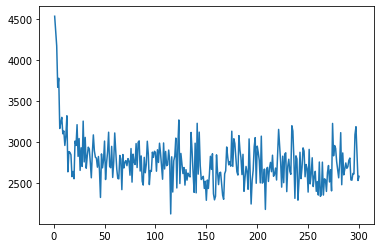

In [78]:
fig = plt.figure()
ax = plt.axes()

x = np.linspace(1, len(res), 300)
ax.plot(x, res);

In [79]:
np.sqrt(np.mean((np.array(inverseTrans(y_test))-np.array(inverseTrans(NN.predict(X_test,y_test)).iloc[:,0]))**2))

/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:200: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


4035206.34588449

In [80]:
NN = NeuralNetwork(Layers=1, Nodes=[50,30,1], NNodes=None, Activations=["Relu","tanh","Relu"], ActivationFn=None, a=None)
start_time = timeit.default_timer()
res = NN.train(X_train,y_train,110,4096,500,10**-3)
elapsed = timeit.default_timer() - start_time
print("Time (minutes) elapsed for this cell:", elapsed/60)
print("Loss:", res[-1])

epoch: 1     Loss: 3800.07409804338
epoch: 2     Loss: 4005.1494112791
epoch: 3     Loss: 3357.088078849992
epoch: 4     Loss: 3350.0311266901817
epoch: 5     Loss: 3358.361355712982
epoch: 6     Loss: 3142.5047927875453
epoch: 7     Loss: 3041.319992718297
epoch: 8     Loss: 2843.2866035971833
epoch: 9     Loss: 3225.7451256882564
epoch: 10     Loss: 2715.3229117356273
epoch: 11     Loss: 2900.0421200847773
epoch: 12     Loss: 2942.435277624297
epoch: 13     Loss: 2933.15943643575
epoch: 14     Loss: 3140.6637955042042
epoch: 15     Loss: 2779.177655920262
epoch: 16     Loss: 2655.5249169383724
epoch: 17     Loss: 2972.95227117518
epoch: 18     Loss: 2932.812906278658
epoch: 19     Loss: 2631.254167020634
epoch: 20     Loss: 2802.9215661711705
epoch: 21     Loss: 2723.4601248218864
epoch: 22     Loss: 2917.1687243233278
epoch: 23     Loss: 2517.7737279060098
epoch: 24     Loss: 2459.887510985456
epoch: 25     Loss: 2355.137380111406
epoch: 26     Loss: 2653.138426662179
epoch: 27     

epoch: 212     Loss: 3006.218164186183
epoch: 213     Loss: 2554.0091693979994
epoch: 214     Loss: 2435.3815396532673
epoch: 215     Loss: 2488.546005785849
epoch: 216     Loss: 2767.023110708515
epoch: 217     Loss: 2343.4112298067516
epoch: 218     Loss: 2826.9510643608714
epoch: 219     Loss: 2455.459541176092
epoch: 220     Loss: 2427.8791790320447
epoch: 221     Loss: 2545.263018371358
epoch: 222     Loss: 2596.60101178164
epoch: 223     Loss: 2604.6229050381658
epoch: 224     Loss: 2213.074724757668
epoch: 225     Loss: 2677.8764100079957
epoch: 226     Loss: 2631.5530580864315
epoch: 227     Loss: 2452.697042520161
epoch: 228     Loss: 2638.342605113927
epoch: 229     Loss: 2721.6218451288523
epoch: 230     Loss: 2335.804501454915
epoch: 231     Loss: 2344.7477856242854
epoch: 232     Loss: 2979.545358767278
epoch: 233     Loss: 2635.458338605956
epoch: 234     Loss: 2899.3319133429036
epoch: 235     Loss: 2791.322313951298
epoch: 236     Loss: 2727.6327493763556
epoch: 237    

epoch: 420     Loss: 2726.8722664651323
epoch: 421     Loss: 2638.2532258387023
epoch: 422     Loss: 2715.867103907755
epoch: 423     Loss: 2641.990482469811
epoch: 424     Loss: 2517.5888777612167
epoch: 425     Loss: 2811.2639848795293
epoch: 426     Loss: 2559.913731885773
epoch: 427     Loss: 2490.4795930460746
epoch: 428     Loss: 3458.1316163062756
epoch: 429     Loss: 2646.178541130878
epoch: 430     Loss: 2611.912067336762
epoch: 431     Loss: 2772.7840367581543
epoch: 432     Loss: 2619.424419839023
epoch: 433     Loss: 2874.3497867919205
epoch: 434     Loss: 3047.0702505947197
epoch: 435     Loss: 2770.759925421081
epoch: 436     Loss: 2539.368927488166
epoch: 437     Loss: 2339.065472597907
epoch: 438     Loss: 2704.701779485238
epoch: 439     Loss: 2882.027741040627
epoch: 440     Loss: 2677.579413243326
epoch: 441     Loss: 2469.002383611399
epoch: 442     Loss: 2669.3974127422534
epoch: 443     Loss: 2892.295960745429
epoch: 444     Loss: 2781.5476298590897
epoch: 445    

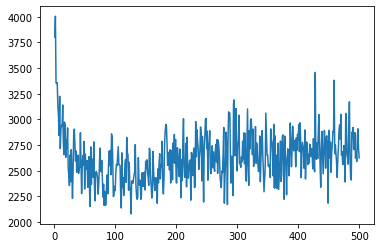

In [82]:
fig = plt.figure()
ax = plt.axes()

x = np.linspace(1, len(res), 500)
ax.plot(x, res);

In [83]:
np.sqrt(np.mean((np.array(inverseTrans(y_test))-np.array(inverseTrans(NN.predict(X_test,y_test)).iloc[:,0]))**2))

/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:200: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


3907202.933322973

In [84]:
NN = NeuralNetwork(Layers=1, Nodes=[50,30,1], NNodes=None, Activations=["Relu","tanh","Relu"], ActivationFn=None, a=None)
start_time = timeit.default_timer()
res = NN.train(X_train,y_train,110,4096,1000,10**-3)
elapsed = timeit.default_timer() - start_time
print("Time (minutes) elapsed for this cell:", elapsed/60)
print("Loss:", res[-1])

epoch: 1     Loss: 3850.879837244589
epoch: 2     Loss: 3622.856040344925
epoch: 3     Loss: 3479.1092114250505
epoch: 4     Loss: 3311.3623981753303
epoch: 5     Loss: 3284.0543350234266
epoch: 6     Loss: 3216.3903753971886
epoch: 7     Loss: 3331.3272975637788
epoch: 8     Loss: 3077.4211105104637
epoch: 9     Loss: 2822.605779043578
epoch: 10     Loss: 2804.9926805810355
epoch: 11     Loss: 3153.3967791739774
epoch: 12     Loss: 3107.1587384783215
epoch: 13     Loss: 2642.1076818098563
epoch: 14     Loss: 2976.419493717661
epoch: 15     Loss: 2570.09599022751
epoch: 16     Loss: 3214.906313835841
epoch: 17     Loss: 2634.768300977442
epoch: 18     Loss: 2992.696383521591
epoch: 19     Loss: 2754.93452283394
epoch: 20     Loss: 2582.955008247162
epoch: 21     Loss: 2714.7690918157214
epoch: 22     Loss: 2891.8409718642706
epoch: 23     Loss: 2725.6419033526313
epoch: 24     Loss: 2872.447946019596
epoch: 25     Loss: 2503.8146529704327
epoch: 26     Loss: 2553.1223005405955
epoch: 2

epoch: 212     Loss: 2254.9677382129053
epoch: 213     Loss: 2835.5335047263397
epoch: 214     Loss: 2917.1373506924424
epoch: 215     Loss: 2579.857534854932
epoch: 216     Loss: 2765.6861744600974
epoch: 217     Loss: 2639.8262715045084
epoch: 218     Loss: 2452.6203804434895
epoch: 219     Loss: 2535.542763948097
epoch: 220     Loss: 2630.111598382103
epoch: 221     Loss: 2758.482260005436
epoch: 222     Loss: 2972.1621011062334
epoch: 223     Loss: 2713.7241555815053
epoch: 224     Loss: 2800.1014753781146
epoch: 225     Loss: 2656.289752988186
epoch: 226     Loss: 2541.2338393641908
epoch: 227     Loss: 2634.487860113059
epoch: 228     Loss: 2873.5026476352505
epoch: 229     Loss: 2883.848666032166
epoch: 230     Loss: 2765.6208462119303
epoch: 231     Loss: 2371.35824016758
epoch: 232     Loss: 2740.018357739778
epoch: 233     Loss: 2599.7146305757146
epoch: 234     Loss: 2860.0579653041214
epoch: 235     Loss: 2596.1972960025137
epoch: 236     Loss: 2648.165757202139
epoch: 237 

epoch: 420     Loss: 3197.5244469734757
epoch: 421     Loss: 2560.3571676799716
epoch: 422     Loss: 2539.255651443118
epoch: 423     Loss: 2923.9829218714717
epoch: 424     Loss: 2795.443335065072
epoch: 425     Loss: 2710.4693261405496
epoch: 426     Loss: 3031.9361636178924
epoch: 427     Loss: 2413.5595784498096
epoch: 428     Loss: 2423.2635083206937
epoch: 429     Loss: 2960.1633436178763
epoch: 430     Loss: 2353.9117375845653
epoch: 431     Loss: 2728.597525484978
epoch: 432     Loss: 2553.187500597141
epoch: 433     Loss: 2396.7148857965094
epoch: 434     Loss: 2679.900168563901
epoch: 435     Loss: 3178.896414895499
epoch: 436     Loss: 3173.667225757119
epoch: 437     Loss: 2552.7094087070054
epoch: 438     Loss: 2925.1757399972344
epoch: 439     Loss: 2924.598506326267
epoch: 440     Loss: 2715.9773637767744
epoch: 441     Loss: 2598.3826750312683
epoch: 442     Loss: 2703.168982743383
epoch: 443     Loss: 2882.543824378364
epoch: 444     Loss: 3032.445519568181
epoch: 445 

epoch: 628     Loss: 2537.926078676349
epoch: 629     Loss: 2627.932280974699
epoch: 630     Loss: 2857.146891794165
epoch: 631     Loss: 2940.6588855351683
epoch: 632     Loss: 2912.798678708837
epoch: 633     Loss: 2753.98469010545
epoch: 634     Loss: 3154.653266814957
epoch: 635     Loss: 2980.5743980939837
epoch: 636     Loss: 2474.4294317302274
epoch: 637     Loss: 2683.7412651079662
epoch: 638     Loss: 2632.8504375116977
epoch: 639     Loss: 2988.741979797831
epoch: 640     Loss: 2469.674511160586
epoch: 641     Loss: 2890.3500051055394
epoch: 642     Loss: 2497.0432385133804
epoch: 643     Loss: 2672.789223459326
epoch: 644     Loss: 2913.426008222285
epoch: 645     Loss: 2454.433292674846
epoch: 646     Loss: 2582.816875102498
epoch: 647     Loss: 2782.8764758397683
epoch: 648     Loss: 2776.0038198726734
epoch: 649     Loss: 2840.821739605965
epoch: 650     Loss: 2371.8898686050675
epoch: 651     Loss: 2959.251266037577
epoch: 652     Loss: 2452.9401847981126
epoch: 653     

epoch: 836     Loss: 2905.070952731977
epoch: 837     Loss: 2506.581964453727
epoch: 838     Loss: 2973.618848320071
epoch: 839     Loss: 2654.085879335035
epoch: 840     Loss: 2876.6652886141273
epoch: 841     Loss: 2515.8158477042202
epoch: 842     Loss: 2708.461464233372
epoch: 843     Loss: 3183.9894035475218
epoch: 844     Loss: 2355.209316794611
epoch: 845     Loss: 2937.2972605295795
epoch: 846     Loss: 2630.0176338132865
epoch: 847     Loss: 2268.755602863724
epoch: 848     Loss: 2630.1682247685344
epoch: 849     Loss: 2679.368063197517
epoch: 850     Loss: 2718.3745271260823
epoch: 851     Loss: 2954.3596768143652
epoch: 852     Loss: 3053.380631800787
epoch: 853     Loss: 2764.9745619080454
epoch: 854     Loss: 2848.2556879252375
epoch: 855     Loss: 3117.0183451763514
epoch: 856     Loss: 3367.1504658660633
epoch: 857     Loss: 3148.591733887164
epoch: 858     Loss: 2978.009216362825
epoch: 859     Loss: 3083.390061609159
epoch: 860     Loss: 2763.0023825876037
epoch: 861  

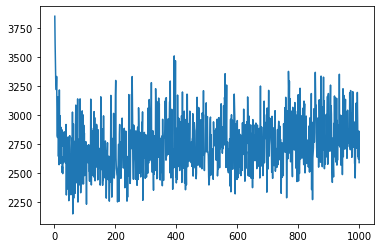

In [85]:
fig = plt.figure()
ax = plt.axes()

x = np.linspace(1, len(res), 1000)
ax.plot(x, res);

In [86]:
np.sqrt(np.mean((np.array(inverseTrans(y_test))-np.array(inverseTrans(NN.predict(X_test,y_test)).iloc[:,0]))**2))

/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:200: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


3646708.2307924787

In [87]:
NN = NeuralNetwork(Layers=1, Nodes=[50,30,1], NNodes=None, Activations=["Relu","tanh","Relu"], ActivationFn=None, a=None)
start_time = timeit.default_timer()
res = NN.train(X_train,y_train,110,4096,5000,10**-3)
elapsed = timeit.default_timer() - start_time
print("Time (minutes) elapsed for this cell:", elapsed/60)
print("Loss:", res[-1])

epoch: 1     Loss: 3647.215400206334
epoch: 2     Loss: 3299.041919733355
epoch: 3     Loss: 3230.171716657954
epoch: 4     Loss: 3160.4212954736176
epoch: 5     Loss: 3528.9898193436634
epoch: 6     Loss: 2885.953523590656
epoch: 7     Loss: 3100.20681001104
epoch: 8     Loss: 2909.1046730289504
epoch: 9     Loss: 3050.476094812153
epoch: 10     Loss: 3323.5913949598894
epoch: 11     Loss: 2895.049987792608
epoch: 12     Loss: 2858.0550227048607
epoch: 13     Loss: 3061.616290144834
epoch: 14     Loss: 2450.061150994566
epoch: 15     Loss: 2410.203882345919
epoch: 16     Loss: 2617.1184388346337
epoch: 17     Loss: 2625.4007951773883
epoch: 18     Loss: 2367.3150533752687
epoch: 19     Loss: 2526.6798390565655
epoch: 20     Loss: 2705.153532248243
epoch: 21     Loss: 2666.960646942181
epoch: 22     Loss: 2368.6904604309116
epoch: 23     Loss: 2639.4798844909387
epoch: 24     Loss: 2213.2997096021836
epoch: 25     Loss: 2816.740342561261
epoch: 26     Loss: 2888.62956384389
epoch: 27  

epoch: 212     Loss: 2374.6042331851118
epoch: 213     Loss: 2323.9608118912083
epoch: 214     Loss: 2481.666463899889
epoch: 215     Loss: 2333.943046078512
epoch: 216     Loss: 3176.9054856103485
epoch: 217     Loss: 2367.9547397565498
epoch: 218     Loss: 2713.274048732608
epoch: 219     Loss: 2902.660788953562
epoch: 220     Loss: 2570.2730771041
epoch: 221     Loss: 2772.735451395663
epoch: 222     Loss: 2687.965104684809
epoch: 223     Loss: 2933.367678213618
epoch: 224     Loss: 2976.6832668114725
epoch: 225     Loss: 2542.5272970561323
epoch: 226     Loss: 2489.2518180864113
epoch: 227     Loss: 2486.6472614429267
epoch: 228     Loss: 2869.379161664249
epoch: 229     Loss: 2518.245544626385
epoch: 230     Loss: 2524.0991838760556
epoch: 231     Loss: 2645.858374414905
epoch: 232     Loss: 2438.847364414499
epoch: 233     Loss: 2655.612606356714
epoch: 234     Loss: 2345.9055160414714
epoch: 235     Loss: 2778.7933044121837
epoch: 236     Loss: 2557.578719077847
epoch: 237     L

epoch: 421     Loss: 2785.779012246703
epoch: 422     Loss: 2888.0916235063637
epoch: 423     Loss: 2857.7786747027485
epoch: 424     Loss: 2536.2914909529177
epoch: 425     Loss: 2676.2449055029615
epoch: 426     Loss: 2605.0426055037237
epoch: 427     Loss: 2558.4372300532846
epoch: 428     Loss: 2402.1754497702673
epoch: 429     Loss: 2531.5118042344075
epoch: 430     Loss: 2280.42503169432
epoch: 431     Loss: 3043.466234639032
epoch: 432     Loss: 2425.637650707383
epoch: 433     Loss: 2410.775628520653
epoch: 434     Loss: 2504.5635854868788
epoch: 435     Loss: 2445.1892296448705
epoch: 436     Loss: 2816.1652118272573
epoch: 437     Loss: 2723.046395088327
epoch: 438     Loss: 2564.6311527808107
epoch: 439     Loss: 2406.746318416324
epoch: 440     Loss: 2474.4511001006376
epoch: 441     Loss: 2972.596829593904
epoch: 442     Loss: 2665.982070033832
epoch: 443     Loss: 3067.105004675867
epoch: 444     Loss: 2561.61387012471
epoch: 445     Loss: 2648.790059285149
epoch: 446    

epoch: 629     Loss: 2968.8153690417275
epoch: 630     Loss: 2583.577415581489
epoch: 631     Loss: 3042.088870834308
epoch: 632     Loss: 2754.521590752143
epoch: 633     Loss: 2439.553021219714
epoch: 634     Loss: 2793.231150854167
epoch: 635     Loss: 2582.311957124633
epoch: 636     Loss: 2491.726811213083
epoch: 637     Loss: 2858.4574096434476
epoch: 638     Loss: 2712.9555623221436
epoch: 639     Loss: 2562.6885538396928
epoch: 640     Loss: 2654.1293484938024
epoch: 641     Loss: 3033.0404691595945
epoch: 642     Loss: 2828.1047558394603
epoch: 643     Loss: 2711.752218130772
epoch: 644     Loss: 2475.3011256000977
epoch: 645     Loss: 2548.6597682737915
epoch: 646     Loss: 2961.2147845805334
epoch: 647     Loss: 2495.4012253616547
epoch: 648     Loss: 2803.1238842485595
epoch: 649     Loss: 2388.2399916962713
epoch: 650     Loss: 2414.507409743683
epoch: 651     Loss: 2859.8583044261063
epoch: 652     Loss: 2636.6424184471684
epoch: 653     Loss: 2491.8629610233675
epoch: 65

epoch: 838     Loss: 2288.361029101529
epoch: 839     Loss: 2800.536166067538
epoch: 840     Loss: 2744.5969201098237
epoch: 841     Loss: 3087.3536604330325
epoch: 842     Loss: 2789.8002077808137
epoch: 843     Loss: 2596.256315948857
epoch: 844     Loss: 2513.4522264387324
epoch: 845     Loss: 2624.875919748367
epoch: 846     Loss: 2663.0906230307214
epoch: 847     Loss: 2824.492181794919
epoch: 848     Loss: 2904.4626220612504
epoch: 849     Loss: 2612.039120694227
epoch: 850     Loss: 2747.1925631676095
epoch: 851     Loss: 2666.969858717802
epoch: 852     Loss: 2360.95451634691
epoch: 853     Loss: 2691.2477993892862
epoch: 854     Loss: 2500.108267364687
epoch: 855     Loss: 2751.1086189284038
epoch: 856     Loss: 3125.361884083247
epoch: 857     Loss: 3125.8898731338036
epoch: 858     Loss: 2832.978344220148
epoch: 859     Loss: 2701.490673572965
epoch: 860     Loss: 3122.6492822342743
epoch: 861     Loss: 2677.0684619548792
epoch: 862     Loss: 2696.859505241848
epoch: 863    

epoch: 1045     Loss: 2783.666638324084
epoch: 1046     Loss: 2799.0821203359887
epoch: 1047     Loss: 2719.717550589907
epoch: 1048     Loss: 2891.4545778513975
epoch: 1049     Loss: 2806.8348582366993
epoch: 1050     Loss: 2839.901743334385
epoch: 1051     Loss: 2848.7170380662187
epoch: 1052     Loss: 2476.994079520828
epoch: 1053     Loss: 2815.292236592368
epoch: 1054     Loss: 3098.224223647312
epoch: 1055     Loss: 2514.874821319748
epoch: 1056     Loss: 2699.613020728973
epoch: 1057     Loss: 2588.1679574175228
epoch: 1058     Loss: 3098.182510663246
epoch: 1059     Loss: 2750.4042822685265
epoch: 1060     Loss: 2975.508412947414
epoch: 1061     Loss: 3018.863231146168
epoch: 1062     Loss: 2567.007144086785
epoch: 1063     Loss: 2733.073265369521
epoch: 1064     Loss: 2636.1490751166443
epoch: 1065     Loss: 3311.4407451895563
epoch: 1066     Loss: 3178.5113171451317
epoch: 1067     Loss: 2657.370994118292
epoch: 1068     Loss: 2856.5027576818675
epoch: 1069     Loss: 2959.493

epoch: 1248     Loss: 2967.7583116923493
epoch: 1249     Loss: 2800.4045547633596
epoch: 1250     Loss: 2720.0734093202755
epoch: 1251     Loss: 2745.371638548996
epoch: 1252     Loss: 2695.9758090293017
epoch: 1253     Loss: 2655.9169153598223
epoch: 1254     Loss: 2883.7171202719196
epoch: 1255     Loss: 3023.428568397666
epoch: 1256     Loss: 2777.3007585870187
epoch: 1257     Loss: 2904.2359022481946
epoch: 1258     Loss: 2776.3723672649294
epoch: 1259     Loss: 2743.4633558426203
epoch: 1260     Loss: 2885.106989284704
epoch: 1261     Loss: 2778.884577563014
epoch: 1262     Loss: 3176.359290217775
epoch: 1263     Loss: 3082.2809966298983
epoch: 1264     Loss: 2961.4089503376676
epoch: 1265     Loss: 2713.3420248256266
epoch: 1266     Loss: 2866.212217197645
epoch: 1267     Loss: 2680.3245729339883
epoch: 1268     Loss: 2777.0358603462278
epoch: 1269     Loss: 3397.7795636565343
epoch: 1270     Loss: 2969.0974564343323
epoch: 1271     Loss: 2809.142538832689
epoch: 1272     Loss: 2

epoch: 1451     Loss: 2604.5734394680794
epoch: 1452     Loss: 3067.553845888768
epoch: 1453     Loss: 2732.605915313481
epoch: 1454     Loss: 2808.1013633527105
epoch: 1455     Loss: 2603.839353156903
epoch: 1456     Loss: 2564.676688545333
epoch: 1457     Loss: 2586.2002461419956
epoch: 1458     Loss: 2927.465951317721
epoch: 1459     Loss: 2469.9294299998587
epoch: 1460     Loss: 2966.2232504105154
epoch: 1461     Loss: 3140.015936344633
epoch: 1462     Loss: 2856.2727108653644
epoch: 1463     Loss: 2998.380727770445
epoch: 1464     Loss: 3061.4588145072507
epoch: 1465     Loss: 2558.3249167445015
epoch: 1466     Loss: 2836.0222297004057
epoch: 1467     Loss: 3115.7056266054697
epoch: 1468     Loss: 3246.1102823769
epoch: 1469     Loss: 3294.404123256934
epoch: 1470     Loss: 2754.9104099252804
epoch: 1471     Loss: 2929.7590343089287
epoch: 1472     Loss: 2909.477147967941
epoch: 1473     Loss: 2897.0924584075237
epoch: 1474     Loss: 2543.7588631500753
epoch: 1475     Loss: 3143.6

epoch: 1654     Loss: 2550.5251443369275
epoch: 1655     Loss: 2783.9895018056463
epoch: 1656     Loss: 2611.8033534546057
epoch: 1657     Loss: 2657.35480382527
epoch: 1658     Loss: 2797.792214576192
epoch: 1659     Loss: 3055.7267328343996
epoch: 1660     Loss: 3042.3476760725916
epoch: 1661     Loss: 2980.713357882712
epoch: 1662     Loss: 2764.243838753593
epoch: 1663     Loss: 2610.9204704802596
epoch: 1664     Loss: 2882.785207032711
epoch: 1665     Loss: 2671.7075745776606
epoch: 1666     Loss: 3274.10210118612
epoch: 1667     Loss: 2655.294984000001
epoch: 1668     Loss: 2941.1218817698436
epoch: 1669     Loss: 2525.1525189831796
epoch: 1670     Loss: 2826.062440279121
epoch: 1671     Loss: 2871.90271620156
epoch: 1672     Loss: 2887.01184395663
epoch: 1673     Loss: 2831.7939203810433
epoch: 1674     Loss: 2777.4229529686495
epoch: 1675     Loss: 2618.176685243126
epoch: 1676     Loss: 2844.966075506458
epoch: 1677     Loss: 2797.4687677856937
epoch: 1678     Loss: 2846.41822

epoch: 1857     Loss: 2496.6405111264585
epoch: 1858     Loss: 2553.888748293445
epoch: 1859     Loss: 2451.5985870039067
epoch: 1860     Loss: 3094.257706531611
epoch: 1861     Loss: 2936.866658564244
epoch: 1862     Loss: 3009.476998978993
epoch: 1863     Loss: 2894.327938066391
epoch: 1864     Loss: 2992.6667807868835
epoch: 1865     Loss: 2982.281823741013
epoch: 1866     Loss: 2995.5507566194246
epoch: 1867     Loss: 2926.4483384415016
epoch: 1868     Loss: 2903.978503577478
epoch: 1869     Loss: 2918.5934871421696
epoch: 1870     Loss: 2891.591235842157
epoch: 1871     Loss: 2912.747670841319
epoch: 1872     Loss: 3086.217620157959
epoch: 1873     Loss: 2866.986363833204
epoch: 1874     Loss: 2974.6249273795647
epoch: 1875     Loss: 2719.7829288292432
epoch: 1876     Loss: 2902.971004335177
epoch: 1877     Loss: 2958.296991434047
epoch: 1878     Loss: 3059.1796825005135
epoch: 1879     Loss: 3218.1476679831508
epoch: 1880     Loss: 3017.815868954445
epoch: 1881     Loss: 2787.989

epoch: 2060     Loss: 3031.209754377953
epoch: 2061     Loss: 3417.284196035529
epoch: 2062     Loss: 2950.723252867688
epoch: 2063     Loss: 2948.192783279375
epoch: 2064     Loss: 2920.6222706937115
epoch: 2065     Loss: 3183.3679025933648
epoch: 2066     Loss: 2887.4464678702775
epoch: 2067     Loss: 2915.361642486513
epoch: 2068     Loss: 3039.4690456876615
epoch: 2069     Loss: 2776.569971195788
epoch: 2070     Loss: 2757.3732989542696
epoch: 2071     Loss: 2970.1136113298057
epoch: 2072     Loss: 3031.1429815358424
epoch: 2073     Loss: 2841.1699348657135
epoch: 2074     Loss: 2872.248309386283
epoch: 2075     Loss: 3127.017488137617
epoch: 2076     Loss: 2788.861252584913
epoch: 2077     Loss: 2885.2717886252367
epoch: 2078     Loss: 2909.553232974856
epoch: 2079     Loss: 3212.8836364407084
epoch: 2080     Loss: 3099.358351475448
epoch: 2081     Loss: 3190.6853804250422
epoch: 2082     Loss: 2855.2923396568212
epoch: 2083     Loss: 3091.152312530979
epoch: 2084     Loss: 2899.9

epoch: 2264     Loss: 3137.9256692054696
epoch: 2265     Loss: 2723.2073553461746
epoch: 2266     Loss: 2682.813060149122
epoch: 2267     Loss: 2921.10544157767
epoch: 2268     Loss: 3041.527475942607
epoch: 2269     Loss: 2793.3952278012544
epoch: 2270     Loss: 3157.939589553754
epoch: 2271     Loss: 3251.219791708485
epoch: 2272     Loss: 3123.6469723381783
epoch: 2273     Loss: 2991.308953419488
epoch: 2274     Loss: 3016.7671328834285
epoch: 2275     Loss: 3076.2157252962184
epoch: 2276     Loss: 3444.042838474781
epoch: 2277     Loss: 3307.215773606525
epoch: 2278     Loss: 3044.965147637545
epoch: 2279     Loss: 2851.3026243145077
epoch: 2280     Loss: 2641.016844844972
epoch: 2281     Loss: 3366.2553875534836
epoch: 2282     Loss: 2955.5358810669168
epoch: 2283     Loss: 3034.3113199183103
epoch: 2284     Loss: 2952.2933021795575
epoch: 2285     Loss: 3232.7717164791975
epoch: 2286     Loss: 3066.8980569804216
epoch: 2287     Loss: 3125.9852386920884
epoch: 2288     Loss: 3205.

epoch: 2467     Loss: 3113.1991225367947
epoch: 2468     Loss: 3151.684049649588
epoch: 2469     Loss: 2934.747105305036
epoch: 2470     Loss: 2697.144697793069
epoch: 2471     Loss: 3054.735974388119
epoch: 2472     Loss: 2408.799604454059
epoch: 2473     Loss: 3524.3457254411405
epoch: 2474     Loss: 3390.0583965513283
epoch: 2475     Loss: 3029.3460679394534
epoch: 2476     Loss: 2817.7621241527395
epoch: 2477     Loss: 2889.6550571589232
epoch: 2478     Loss: 3193.7587657979398
epoch: 2479     Loss: 3355.503578845709
epoch: 2480     Loss: 3418.153357057079
epoch: 2481     Loss: 3360.5485143730093
epoch: 2482     Loss: 2941.4897610838448
epoch: 2483     Loss: 3346.6210789371294
epoch: 2484     Loss: 2949.87718142935
epoch: 2485     Loss: 3588.1513772170574
epoch: 2486     Loss: 2723.7197160709543
epoch: 2487     Loss: 3033.0277358683716
epoch: 2488     Loss: 3269.314508556583
epoch: 2489     Loss: 2678.5912924461954
epoch: 2490     Loss: 3088.0064563197516
epoch: 2491     Loss: 3004

epoch: 2670     Loss: 2762.573255574007
epoch: 2671     Loss: 2996.094923055651
epoch: 2672     Loss: 3164.5734733230543
epoch: 2673     Loss: 2913.493919934643
epoch: 2674     Loss: 2874.2588695282134
epoch: 2675     Loss: 3458.8856170063764
epoch: 2676     Loss: 2872.2682815725584
epoch: 2677     Loss: 3162.05848964029
epoch: 2678     Loss: 3168.833820583419
epoch: 2679     Loss: 3000.2187298971853
epoch: 2680     Loss: 3150.8622233122455
epoch: 2681     Loss: 2818.8484855788242
epoch: 2682     Loss: 3092.560374732732
epoch: 2683     Loss: 2868.9765026739324
epoch: 2684     Loss: 2871.2304044677235
epoch: 2685     Loss: 2903.592820120158
epoch: 2686     Loss: 3433.1128545319702
epoch: 2687     Loss: 3468.08882559895
epoch: 2688     Loss: 2979.248519584211
epoch: 2689     Loss: 3474.416774030642
epoch: 2690     Loss: 3029.776945198651
epoch: 2691     Loss: 2711.4482016646684
epoch: 2692     Loss: 2987.762167946747
epoch: 2693     Loss: 2894.4236341666397
epoch: 2694     Loss: 2796.174

epoch: 2873     Loss: 2732.174657986937
epoch: 2874     Loss: 3068.7368469892194
epoch: 2875     Loss: 2898.5526079812116
epoch: 2876     Loss: 3082.3704003084717
epoch: 2877     Loss: 3151.6494492303354
epoch: 2878     Loss: 3113.746968558518
epoch: 2879     Loss: 2692.748750814265
epoch: 2880     Loss: 2934.3134560332733
epoch: 2881     Loss: 2707.7908393750745
epoch: 2882     Loss: 2829.65161896692
epoch: 2883     Loss: 2756.3599467168674
epoch: 2884     Loss: 2971.6399993883615
epoch: 2885     Loss: 2476.6441975776934
epoch: 2886     Loss: 2975.799683729129
epoch: 2887     Loss: 3244.4038247650265
epoch: 2888     Loss: 3316.7413554953305
epoch: 2889     Loss: 3144.771938905437
epoch: 2890     Loss: 2787.9242114932367
epoch: 2891     Loss: 3121.6266820947867
epoch: 2892     Loss: 2933.5536243248393
epoch: 2893     Loss: 2942.4414334418525
epoch: 2894     Loss: 3097.833063492125
epoch: 2895     Loss: 3525.575700821221
epoch: 2896     Loss: 3181.764894664038
epoch: 2897     Loss: 2801

epoch: 3075     Loss: 3412.0099079378565
epoch: 3076     Loss: 2960.894144804873
epoch: 3077     Loss: 3079.858749348739
epoch: 3078     Loss: 2778.704792275608
epoch: 3079     Loss: 3107.530694925196
epoch: 3080     Loss: 3219.391032826432
epoch: 3081     Loss: 3111.8403362457043
epoch: 3082     Loss: 2740.2183694337914
epoch: 3083     Loss: 2855.814526671734
epoch: 3084     Loss: 3261.9209650800126
epoch: 3085     Loss: 3205.4325438851524
epoch: 3086     Loss: 3183.2768401680987
epoch: 3087     Loss: 3097.8748076796373
epoch: 3088     Loss: 3247.588841177978
epoch: 3089     Loss: 3106.297985420308
epoch: 3090     Loss: 3092.758153811363
epoch: 3091     Loss: 2572.4165750724687
epoch: 3092     Loss: 2816.4139216295152
epoch: 3093     Loss: 3245.6352543521043
epoch: 3094     Loss: 3115.647722179245
epoch: 3095     Loss: 3101.0126797960893
epoch: 3096     Loss: 3406.355618774246
epoch: 3097     Loss: 3355.875843408944
epoch: 3098     Loss: 2826.329151366507
epoch: 3099     Loss: 2918.41

epoch: 3278     Loss: 2932.6331287918256
epoch: 3279     Loss: 3045.4116022603243
epoch: 3280     Loss: 2965.535885349613
epoch: 3281     Loss: 3001.644251909119
epoch: 3282     Loss: 2990.0725436579933
epoch: 3283     Loss: 2988.25036802823
epoch: 3284     Loss: 3039.367121353599
epoch: 3285     Loss: 2897.01347697507
epoch: 3286     Loss: 3081.106444423458
epoch: 3287     Loss: 3240.437539176946
epoch: 3288     Loss: 2930.401783450073
epoch: 3289     Loss: 3027.4833010455714
epoch: 3290     Loss: 3168.5454463211177
epoch: 3291     Loss: 3269.2102202358287
epoch: 3292     Loss: 2942.320224455782
epoch: 3293     Loss: 3087.015514561056
epoch: 3294     Loss: 2952.402001208627
epoch: 3295     Loss: 3180.733806527318
epoch: 3296     Loss: 2821.9094443106833
epoch: 3297     Loss: 3012.765905449906
epoch: 3298     Loss: 2965.1419852844997
epoch: 3299     Loss: 3005.3811770234647
epoch: 3300     Loss: 2647.866315449459
epoch: 3301     Loss: 2836.518557703627
epoch: 3302     Loss: 3268.355492

epoch: 3481     Loss: 3240.0080073089175
epoch: 3482     Loss: 3057.159342780595
epoch: 3483     Loss: 3095.2530843557774
epoch: 3484     Loss: 3233.1773565638146
epoch: 3485     Loss: 3178.334650601056
epoch: 3486     Loss: 2918.811500767522
epoch: 3487     Loss: 3317.07472587054
epoch: 3488     Loss: 2939.887375337857
epoch: 3489     Loss: 3100.5202171626247
epoch: 3490     Loss: 3068.360167593558
epoch: 3491     Loss: 3049.9328281478547
epoch: 3492     Loss: 3310.192405566466
epoch: 3493     Loss: 3195.098016059469
epoch: 3494     Loss: 2881.5679191278623
epoch: 3495     Loss: 2945.75748565273
epoch: 3496     Loss: 2922.5503914208725
epoch: 3497     Loss: 3220.414994736141
epoch: 3498     Loss: 2950.8288446236543
epoch: 3499     Loss: 2662.391908698666
epoch: 3500     Loss: 2892.166920730047
epoch: 3501     Loss: 3471.926061444528
epoch: 3502     Loss: 2819.7005703900054
epoch: 3503     Loss: 2884.976210995793
epoch: 3504     Loss: 3573.2977868317084
epoch: 3505     Loss: 3907.00736

epoch: 3684     Loss: 3126.0373354316407
epoch: 3685     Loss: 2659.556783471372
epoch: 3686     Loss: 3181.5264425976143
epoch: 3687     Loss: 3157.7055459113867
epoch: 3688     Loss: 2783.6487945807544
epoch: 3689     Loss: 2758.1193199307277
epoch: 3690     Loss: 2828.396053180216
epoch: 3691     Loss: 3264.0513152625645
epoch: 3692     Loss: 2989.9507627686785
epoch: 3693     Loss: 2966.1166285510535
epoch: 3694     Loss: 3016.595126867101
epoch: 3695     Loss: 2888.8291236167747
epoch: 3696     Loss: 3011.3606325805936
epoch: 3697     Loss: 2987.6038877622095
epoch: 3698     Loss: 3208.0480412946167
epoch: 3699     Loss: 2841.6635969983463
epoch: 3700     Loss: 3130.4653991255295
epoch: 3701     Loss: 2940.7843521267946
epoch: 3702     Loss: 2691.9459100450217
epoch: 3703     Loss: 2959.6718482164883
epoch: 3704     Loss: 2875.117902361629
epoch: 3705     Loss: 3170.3009116940684
epoch: 3706     Loss: 3084.6004393878893
epoch: 3707     Loss: 3009.4196737018283
epoch: 3708     Loss

epoch: 3887     Loss: 2868.606975897205
epoch: 3888     Loss: 3025.2247458166635
epoch: 3889     Loss: 2986.0615694137655
epoch: 3890     Loss: 2908.2801566736293
epoch: 3891     Loss: 2975.571203975555
epoch: 3892     Loss: 3328.593744331531
epoch: 3893     Loss: 3096.1381742556405
epoch: 3894     Loss: 3145.565612367523
epoch: 3895     Loss: 2863.4123922773465
epoch: 3896     Loss: 2660.8449259604654
epoch: 3897     Loss: 3477.8090933672183
epoch: 3898     Loss: 3545.3495739736927
epoch: 3899     Loss: 2637.293795987278
epoch: 3900     Loss: 2932.235340351117
epoch: 3901     Loss: 3183.758582635584
epoch: 3902     Loss: 3249.6038662841893
epoch: 3903     Loss: 3281.2671052262795
epoch: 3904     Loss: 3112.389603485056
epoch: 3905     Loss: 2618.651569629237
epoch: 3906     Loss: 3134.182211451868
epoch: 3907     Loss: 3130.820729448647
epoch: 3908     Loss: 2777.1659701459007
epoch: 3909     Loss: 3141.9107928838175
epoch: 3910     Loss: 3036.8665370054937
epoch: 3911     Loss: 2753.

epoch: 4091     Loss: 3068.6496608260686
epoch: 4092     Loss: 3220.434687010501
epoch: 4093     Loss: 3270.574177897206
epoch: 4094     Loss: 3156.9973528834466
epoch: 4095     Loss: 3128.5111083196593
epoch: 4096     Loss: 3216.2314980278165
epoch: 4097     Loss: 2886.18627089853
epoch: 4098     Loss: 2874.1101683930365
epoch: 4099     Loss: 3030.05547307055
epoch: 4100     Loss: 2896.2342608643576
epoch: 4101     Loss: 2891.80168906375
epoch: 4102     Loss: 2973.3053005645274
epoch: 4103     Loss: 3032.503655150629
epoch: 4104     Loss: 2839.05011469021
epoch: 4105     Loss: 3019.5211161711322
epoch: 4106     Loss: 2822.887550284667
epoch: 4107     Loss: 3150.4744666689917
epoch: 4108     Loss: 2774.9294329185636
epoch: 4109     Loss: 2923.8387882791094
epoch: 4110     Loss: 3033.193564034043
epoch: 4111     Loss: 2857.895933676938
epoch: 4112     Loss: 2944.5923024753947
epoch: 4113     Loss: 2466.7767537676987
epoch: 4114     Loss: 3080.2436350514195
epoch: 4115     Loss: 3424.305

epoch: 4294     Loss: 2932.731134773418
epoch: 4295     Loss: 2819.2246742290104
epoch: 4296     Loss: 2941.6402004412107
epoch: 4297     Loss: 2660.3730707061422
epoch: 4298     Loss: 3109.455757195396
epoch: 4299     Loss: 2860.7899451905964
epoch: 4300     Loss: 2775.520260534504
epoch: 4301     Loss: 3070.373967429157
epoch: 4302     Loss: 2803.156586347075
epoch: 4303     Loss: 3034.1018035281595
epoch: 4304     Loss: 3130.106706363537
epoch: 4305     Loss: 3068.040312205463
epoch: 4306     Loss: 2965.428167282919
epoch: 4307     Loss: 3000.6437576158232
epoch: 4308     Loss: 3305.975179887548
epoch: 4309     Loss: 2939.186285635034
epoch: 4310     Loss: 3200.191088261657
epoch: 4311     Loss: 2826.987283703759
epoch: 4312     Loss: 3031.9412745950062
epoch: 4313     Loss: 2849.560778165223
epoch: 4314     Loss: 3281.416504506686
epoch: 4315     Loss: 3475.490517508844
epoch: 4316     Loss: 3063.338366900236
epoch: 4317     Loss: 2836.7712178848346
epoch: 4318     Loss: 2712.27283

epoch: 4497     Loss: 3439.4858060218303
epoch: 4498     Loss: 3025.896435448683
epoch: 4499     Loss: 3043.410430766831
epoch: 4500     Loss: 2794.1806071107135
epoch: 4501     Loss: 2718.536281268907
epoch: 4502     Loss: 3210.458239482745
epoch: 4503     Loss: 2679.3494329282407
epoch: 4504     Loss: 3246.729720316205
epoch: 4505     Loss: 3101.538869137471
epoch: 4506     Loss: 3430.5424315978903
epoch: 4507     Loss: 3283.83416456432
epoch: 4508     Loss: 3052.8452241947866
epoch: 4509     Loss: 3090.91698200284
epoch: 4510     Loss: 3370.9577632422083
epoch: 4511     Loss: 3121.8344945533113
epoch: 4512     Loss: 3164.554288724014
epoch: 4513     Loss: 2721.8143552363213
epoch: 4514     Loss: 3186.9679443482587
epoch: 4515     Loss: 2970.3338935697675
epoch: 4516     Loss: 2846.751350946205
epoch: 4517     Loss: 2867.3263613860304
epoch: 4518     Loss: 3231.5144644111524
epoch: 4519     Loss: 3298.7057327387597
epoch: 4520     Loss: 3515.8375708799394
epoch: 4521     Loss: 3241.4

epoch: 4700     Loss: 3089.496505946822
epoch: 4701     Loss: 2916.221471121753
epoch: 4702     Loss: 2876.2348152458753
epoch: 4703     Loss: 3086.621100076565
epoch: 4704     Loss: 3464.16920920305
epoch: 4705     Loss: 3136.2688184675335
epoch: 4706     Loss: 3240.271330004469
epoch: 4707     Loss: 2639.4147507118782
epoch: 4708     Loss: 3001.079099608455
epoch: 4709     Loss: 3448.9911103412705
epoch: 4710     Loss: 3329.5693477942
epoch: 4711     Loss: 3446.512372658698
epoch: 4712     Loss: 2749.6668469990896
epoch: 4713     Loss: 3295.0786693819446
epoch: 4714     Loss: 3057.3330516298115
epoch: 4715     Loss: 2823.6431106198556
epoch: 4716     Loss: 2831.1996271904554
epoch: 4717     Loss: 2812.3352449583645
epoch: 4718     Loss: 3354.6841835823793
epoch: 4719     Loss: 2616.2728993683263
epoch: 4720     Loss: 2882.186861721173
epoch: 4721     Loss: 3125.662073370633
epoch: 4722     Loss: 3641.785329754101
epoch: 4723     Loss: 3111.2564453256036
epoch: 4724     Loss: 3054.057

epoch: 4903     Loss: 2887.6204832184653
epoch: 4904     Loss: 3202.89291512341
epoch: 4905     Loss: 3400.2483558486565
epoch: 4906     Loss: 3384.2253764826605
epoch: 4907     Loss: 2958.8708012647025
epoch: 4908     Loss: 2477.300422787337
epoch: 4909     Loss: 2777.216880361874
epoch: 4910     Loss: 3417.3469363717804
epoch: 4911     Loss: 3362.9315516232323
epoch: 4912     Loss: 3536.3775780865885
epoch: 4913     Loss: 2958.944535670684
epoch: 4914     Loss: 2911.6713067521223
epoch: 4915     Loss: 2777.9395702771244
epoch: 4916     Loss: 3002.48605188422
epoch: 4917     Loss: 3065.520782858884
epoch: 4918     Loss: 2966.243236757711
epoch: 4919     Loss: 2554.5149992402735
epoch: 4920     Loss: 2915.975911660294
epoch: 4921     Loss: 2907.5054979706965
epoch: 4922     Loss: 3323.3646045717355
epoch: 4923     Loss: 3142.606341602658
epoch: 4924     Loss: 2660.5759859846116
epoch: 4925     Loss: 2916.914475574194
epoch: 4926     Loss: 3086.2343294989555
epoch: 4927     Loss: 3008.0

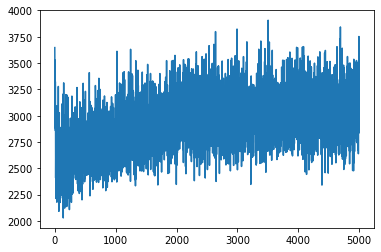

In [88]:
fig = plt.figure()
ax = plt.axes()

x = np.linspace(1, len(res), 5000)
ax.plot(x, res);

In [89]:
np.sqrt(np.mean((np.array(inverseTrans(y_test))-np.array(inverseTrans(NN.predict(X_test,y_test)).iloc[:,0]))**2))

/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:200: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


3182509.8334885524

In [100]:
NN = NeuralNetwork(Layers=1, Nodes=[50,30,1], NNodes=None, Activations=["Relu","tanh","Relu"], ActivationFn=None, a=None)
start_time = timeit.default_timer()
res = NN.train(X_train,y_train,110,4096,100,10**-3)
elapsed = timeit.default_timer() - start_time
print("Time (minutes) elapsed for this cell:", elapsed/60)
print("Loss:", res[-1])

epoch: 1     Loss: 5066.220050390363
epoch: 2     Loss: 5190.951480202706
epoch: 3     Loss: 3929.9354503483682
epoch: 4     Loss: 3768.7623807927625
epoch: 5     Loss: 5506.6833170308155
epoch: 6     Loss: 3397.857545399672
epoch: 7     Loss: 3393.01677501281
epoch: 8     Loss: 3074.4750191245157
epoch: 9     Loss: 3628.9554753689185
epoch: 10     Loss: 2850.5028133599053
epoch: 11     Loss: 3298.9951720612135
epoch: 12     Loss: 2821.411177435269
epoch: 13     Loss: 3174.887031124511
epoch: 14     Loss: 2999.134757936769
epoch: 15     Loss: 3111.293006963243
epoch: 16     Loss: 3022.738803561211
epoch: 17     Loss: 3000.6851668513104
epoch: 18     Loss: 2804.405043300883
epoch: 19     Loss: 2859.4867720100337
epoch: 20     Loss: 2946.6944342314064
epoch: 21     Loss: 2613.0626308611854
epoch: 22     Loss: 3194.337371379378
epoch: 23     Loss: 2588.260407570536
epoch: 24     Loss: 2650.8230216727793
epoch: 25     Loss: 2920.445002936485
epoch: 26     Loss: 2677.1012695739187
epoch: 27

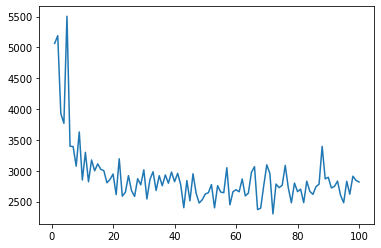

In [101]:
fig = plt.figure()
ax = plt.axes()

x = np.linspace(1, len(res), 100)
ax.plot(x, res);

In [102]:
np.sqrt(np.mean((np.array(inverseTrans(y_test))-np.array(inverseTrans(NN.predict(X_test,y_test)).iloc[:,0]))**2))

/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:200: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


4378595.169117802